# Guided backpropagation for all_model

Source:
https://github.com/arazd/saliency-tensorflow2/blob/master/methods/base.py


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from typing import List

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

import keras

import tensorflow as tf


2024-05-14 16:04:57.699989: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 16:04:57.716432: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 16:04:57.795617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 16:04:58.962008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def set_reproducible():
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

In [3]:
dps1200 = pd.read_csv("/home/mel/Masterthesis/Masterthesis_code/raw_data/csv/dps1200_all.csv")

In [4]:
dps1200.rename(columns=lambda x: x.replace('X', ''), inplace=True)

In [5]:
y = dps1200.iloc[:,4:]
xp = y.columns.values
xp = xp.astype(int)

In [6]:
features = dps1200.iloc[:, 4:].values
labels = dps1200.iloc[:, 0].values

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [8]:
print(test_data.shape)

(260, 1866)


In [9]:
model_path = "/home/mel/Masterthesis/Masterthesis_code/code/all_data/dps1200all_model.keras"

In [10]:
dps1200all_model = tf.keras.models.load_model(model_path)

# Show the model architecture
dps1200all_model.summary()

2024-05-14 16:05:01.331005: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35988160 exceeds 10% of free system memory.
2024-05-14 16:05:01.351953: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35988160 exceeds 10% of free system memory.
2024-05-14 16:05:01.373941: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35988160 exceeds 10% of free system memory.
2024-05-14 16:05:01.485511: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35988160 exceeds 10% of free system memory.
2024-05-14 16:05:01.495201: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35988160 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 1866, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1833, 24)       │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 916, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 820, 52)        │       121,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 410, 52)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 422)            │     8,997,462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           423 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,501 (104.37 MB)

 Trainable params: 9,119,833 (34.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,239,668 (69.58 MB)

# Guided Backpropagation

In [11]:
class SaliencyMap():
    def __init__(self, model):
        self.model = model
    def get_top_predicted_idx(self, test_data):
        """Outputs top predicted class for the input image.

        Args:
            img_processed: numpy image array in NHWC format, pre-processed according
                to the defined model standard.

        Returns:
            Index of the top predicted class for the input image.
        """
        preds = self.model.predict(test_data)
        top_pred_idx = tf.argmax(preds[0])
        return top_pred_idx


    def get_gradients(self, test_data):
        """Computes the gradients of outputs w.r.t input image.

        Args:
            image: numpy image array in NHWC format, pre-processed according
                to the defined model standard.

        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        test_data = tf.convert_to_tensor(test_data)
        top_pred_idx = self.get_top_predicted_idx(test_data)

        with tf.GradientTape() as tape:
            tape.watch(test_data)
            preds = self.model(test_data)
            top_class = preds[:, top_pred_idx]

        grads = tape.gradient(top_class, test_data)
        return grads


    def norm_grad(self, grad_x):
        """Normalizes gradient to the range between 0 and 1
        (for visualization purposes).

        Args:
            grad_x: numpy gradients array.

        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        abs_grads = np.abs(grad_x)
        grad_max_ = np.max(abs_grads, axis=3)[0]
        arr_min, arr_max  = np.min(grad_max_), np.max(grad_max_)
        normalized_grad = (grad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
        normalized_grad = normalized_grad.reshape(1,grad_x.shape[1],grad_x.shape[2],1)

        return normalized_grad


    def get_mask(self, test_data, tensor_format=False):
        """Returns a saliency mask specific to each method.

        Args:
            image: input image in NHWC format, not batched.
        """
        raise NotImplementedError('A derived class should implement get_mask()')

In [12]:
class GuidedBackprop(SaliencyMap):
    def get_mask(self, test_data, preprocess=True):
        """Computes Integrated Gradients for a predicted label.

        Args:
            image (ndarray): Original image
            top_pred_idx: Predicted label for the input image
            baseline (ndarray): The baseline image to start with for interpolation
            num_steps: Number of interpolation steps between the baseline
                and the input used in the computation of integrated gradients. These
                steps along determine the integral approximation error. By default,
                num_steps is set to 50.

        Returns:
            Integrated gradients w.r.t input image
        """

        def guidedRelu(x):
            def grad(dy):
                return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
            return tf.nn.relu(x), grad
        
        guided_relu_model = tf.keras.Model(
                inputs = self.model.inputs,
                outputs = self.model.outputs
            )
        relu_layers = []
        for i in guided_relu_model.layers:
            if i.name != "gaussian_noise":
                if hasattr(i, "activation"):
                    print(i.activation)
                    relu_layers.append(i)
        print(relu_layers)
        for layer in relu_layers:
            layer.activation = guidedRelu
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(test_data, tf.float32)
            tape.watch(inputs)
            outputs = guided_relu_model(inputs)

        grads = tape.gradient(outputs, inputs)
        return grads

In [13]:
guided_back = GuidedBackprop(dps1200all_model)
grads = guided_back.get_mask(test_data)

<function relu at 0x7f5700611440>
<function relu at 0x7f5700611440>
<function relu at 0x7f5700611440>
<function relu at 0x7f5700611440>
[<Conv1D name=conv1d, built=True>, <Conv1D name=conv1d_1, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>]


In [14]:
#print(grads)
print(grads.shape)
print(xp.shape)

(260, 1866)
(1866,)


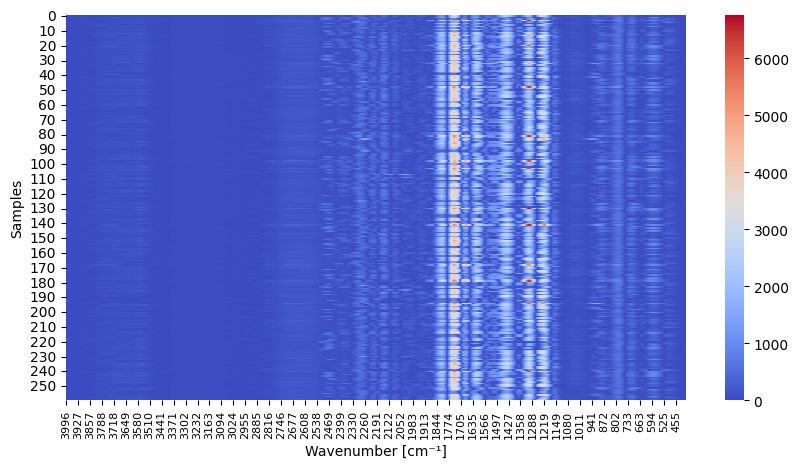

In [15]:
grads = np.abs(grads)
wavelengths = xp[::36]

# Plot Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(grads, cmap='coolwarm')
plt.xlabel('Wavenumber [cm⁻¹]')
plt.ylabel('Samples')
#plt.title('Saliency Heatmap')
plt.xticks(ticks=np.arange(0.5, grads.shape[1] + 0.5, 36), labels=wavelengths, fontsize=8)
plt.show()

## Feature importance for sorted samples

In [16]:
test_labels_2d = test_labels.reshape(-1, 1)
test_all = np.concatenate((test_labels_2d, test_data), axis=1)


sorted_indices = np.argsort(test_all[:, 0])
test_all_sorted = test_all[sorted_indices]

sorted_test_labels = test_all_sorted[:, 0]
sorted_test_data = test_all_sorted[:, 1:]

#print("Sorted Labels:")
#print(sorted_test_labels)
#print("\nSorted Data:")
#print(sorted_test_data)

In [17]:
back_prop_sorted_data = GuidedBackprop(dps1200all_model)
sorted_grads = back_prop_sorted_data.get_mask(sorted_test_data)

<function GuidedBackprop.get_mask.<locals>.guidedRelu at 0x7f56ffffce00>
<function GuidedBackprop.get_mask.<locals>.guidedRelu at 0x7f56ffffce00>
<function GuidedBackprop.get_mask.<locals>.guidedRelu at 0x7f56ffffce00>
<function GuidedBackprop.get_mask.<locals>.guidedRelu at 0x7f56ffffce00>
[<Conv1D name=conv1d, built=True>, <Conv1D name=conv1d_1, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>]


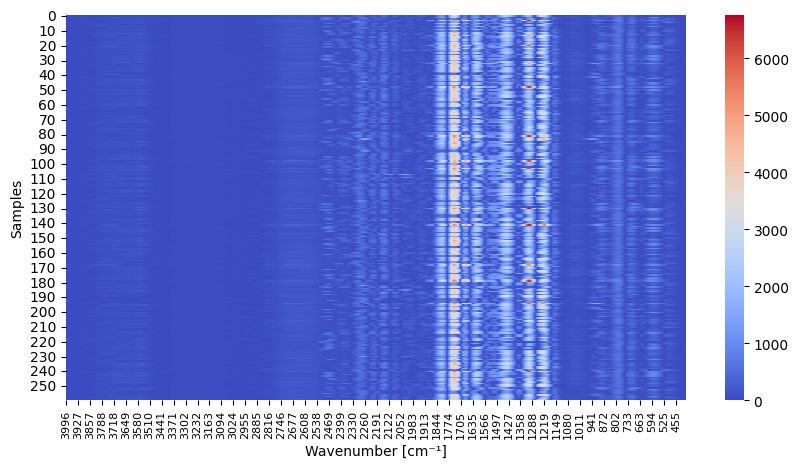

In [18]:
sorted_grads = np.abs(sorted_grads)
wavelengths = xp[::36]

# Plot Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(grads, cmap='coolwarm')
plt.xlabel('Wavenumber [cm⁻¹]')
plt.ylabel('Samples')
#plt.title('Saliency Heatmap')
plt.xticks(ticks=np.arange(0.5, grads.shape[1] + 0.5, 36), labels=wavelengths, fontsize=8)
plt.show()

## Feature importance for each century

In [19]:
def convertToCentury(y: List[int]) -> List[int]: 
    return [int(str(year)[:2]) for year in y]
centuries = convertToCentury(sorted_test_labels)
#print(centuries)

In [20]:
unique_centuries, counts = np.unique(centuries, return_counts=True)
#print(unique_centuries, counts)
#print(len(counts))

In [21]:
mean_values = []
i = 0
output_height = len(counts)
output_width = sorted_grads.shape[1]

sorted_grads2 = np.zeros((output_height, output_width))

start_row = 0
for count in counts:
    group_data = sorted_grads[start_row:start_row+count]
    group_mean = np.mean(group_data, axis=0)    
    sorted_grads2[i,:] += group_mean
    i += 1
    start_row += count

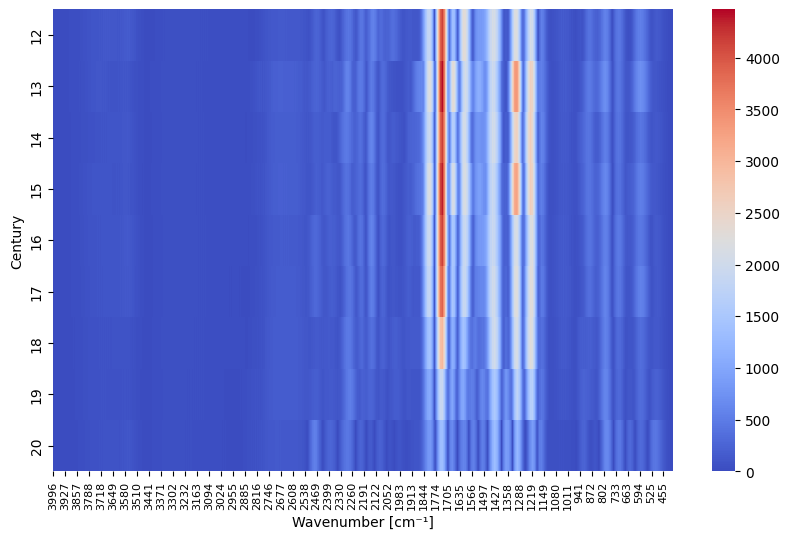

In [22]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(sorted_grads2, cmap='coolwarm')
wavelengths = xp[::36]
plt.xticks(ticks=np.arange(0.5, sorted_grads2.shape[1] + 0.5, 36), labels=wavelengths, fontsize=8)
plt.xlabel('Wavenumber [cm⁻¹]')

centuries = unique_centuries
plt.yticks(ticks=np.arange(0.5, sorted_grads2.shape[0] + 0.5), labels=centuries)
plt.ylabel('Century')
plt.show()

# Heatmap for Comparison

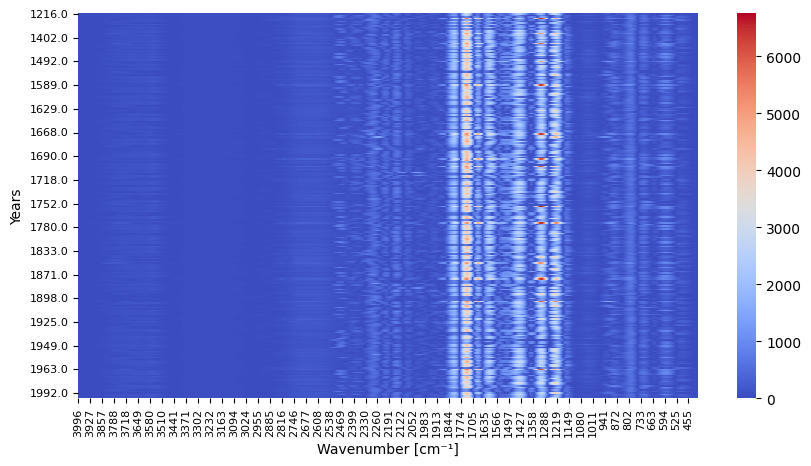

In [23]:
# Plot Heatmap
wavelengths = xp[::36]

years = sorted_test_labels[::16]

# Plot Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(grads, cmap='coolwarm')
plt.xlabel('Wavenumber [cm⁻¹]')
plt.ylabel('Years')
plt.xticks(ticks=np.arange(0.5, grads.shape[1] + 0.5, 36), labels=wavelengths, fontsize=8)
plt.yticks(ticks=np.arange(0.5, grads.shape[0] + 0.5, 16), labels=years, fontsize=8)
plt.show()